## Imports

In [59]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(transform_output = 'pandas')


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os
shap.initjs()

In [60]:
## Importing Custom Functions
import sys,os
# sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
#from CODE import data_enrichment as de

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
    
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

##  Loading Objects from a Joblib

In [62]:
# load the data

loaded = joblib.load('Sales-Predictionsbest-models.joblib')
loaded.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])

In [63]:
## Saving the loaded objects as separate varaibles

X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,NCS30,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,FDI08,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


## Re-Creating X_train_df & X_test_df

In [64]:
## Use the preprocessor to transform X_train into X_train_proc
X_train_proc = preprocessor.transform(X_train)


## Use the preprocessor to transform X_test into X_test_df 

X_test_proc = preprocessor.transform(X_test)

X_train_proc.head()

,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8269,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,7.220,0.064142,61.2510,1998.0
7604,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,6.135,0.079294,111.2860,2009.0
2762,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,12.150,0.028593,151.0708,2004.0
6464,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5.945,0.093009,127.8652,2004.0
4707,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,18.200,0.066285,247.2092,2004.0


In [65]:
len(X_train)

6392

## Global Model Explanations

### Applying Shap

In [66]:
# Import and init shap
import shap
shap.initjs()

## Gather a small random sample to speed the process

In [67]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train_proc, nsamples = 500, random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
4469,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.72,0.074669,76.3986,1987.0
4438,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5.11,0.034868,163.8210,2004.0
366,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,8.05,0.078386,256.4646,2004.0
2219,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,8.76,0.050131,128.3336,1999.0
6080,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,6.59,0.176748,82.7908,1998.0


In [68]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
          ...    
6181    4844.3608
717     1810.9760
6789    5932.2780
3608     302.9390
2472     188.4214
Name: Item_Outlet_Sales, Length: 500, dtype: float64

## Create SHAP Explainer and SHAP Values for Random Forest Model

In [69]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
rf_shap_values = rf_explainer(X_shap)

In [70]:
rf_shap_values.shape

(500, 28)

## Shap Values Contents

Shap values includes the values for each feature, base values, and original data FOR EACH ROW

So, 500 rows by 28 features

In [71]:
rf_shap_values[0]

.values =
array([-1.46193600e+01, -3.80234922e+01,  1.40028559e+01,  9.38391183e+00,
       -1.36560039e+00,  1.69027335e+01, -3.70397439e-02, -7.92587505e+00,
       -8.48249801e-01,  1.38912778e+00, -2.37247226e+00, -5.86573073e-01,
       -5.22611859e-01,  3.58750311e+00,  5.62682281e-01, -9.38536830e-02,
       -3.74578046e-01, -2.20440962e+00, -1.06890953e+00, -1.26871468e+00,
        2.07878298e+02,  4.85604337e+00,  5.74922365e+00, -7.54851072e+01,
        7.08571516e+01,  2.81593938e+01, -9.47579448e+02, -7.62988224e+01])

.base_values =
array([2154.71233664])

.data =
array([2.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       7.72000

## Summary Bar Plot: Random Forest

The show=False flag will allow us to manipulate the figure using matplotlib.

Text(0.5, 1.0, 'Random Forest SHAP Summary')

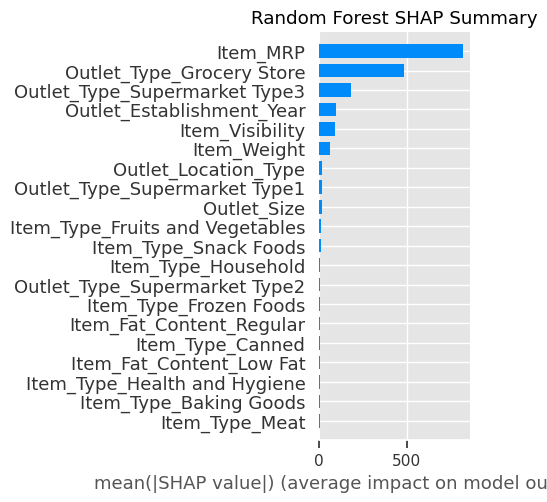

In [75]:
## create a summary plot (bar version)
fig = shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar',
                 show=False, plot_size=[5,5])

plt.title('Random Forest SHAP Summary')

In [77]:
print(type(fig))
fig

<class 'NoneType'>


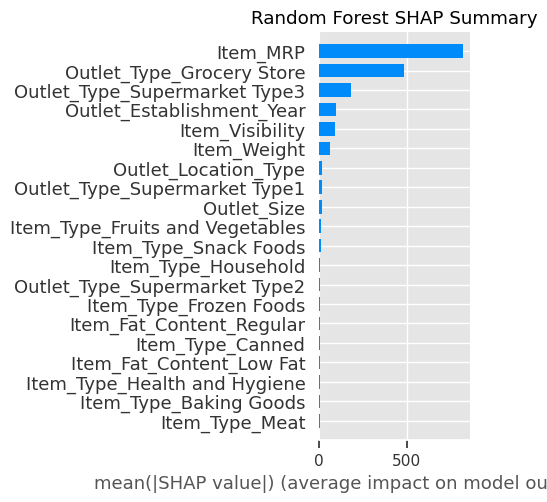

In [81]:
# save visualization
fig, ax = plt.subplots()
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar',
                 show=False, plot_size=[5,5])
ax.set_title('Random Forest SHAP Summary')

fig.savefig('images/RFShapbarplot.png')

<img src="images/top5mostimportantfeatures.png" width=60%>

According to SHAP the most important features are the:

* Item_MRP
* Outlet_Type_Grocery_Store
* Outlet_Type_Supermarket Type3
* Outlet_Establishment_Year
* Item_Visibility

Both of these Models have 4 out of 5 features that are the same. The difference with the SHAP model is the Outlet_Establishment_year feature is of higher importance than the Item_Weight. 

## SHAP Dot Plot for Random Forest Model

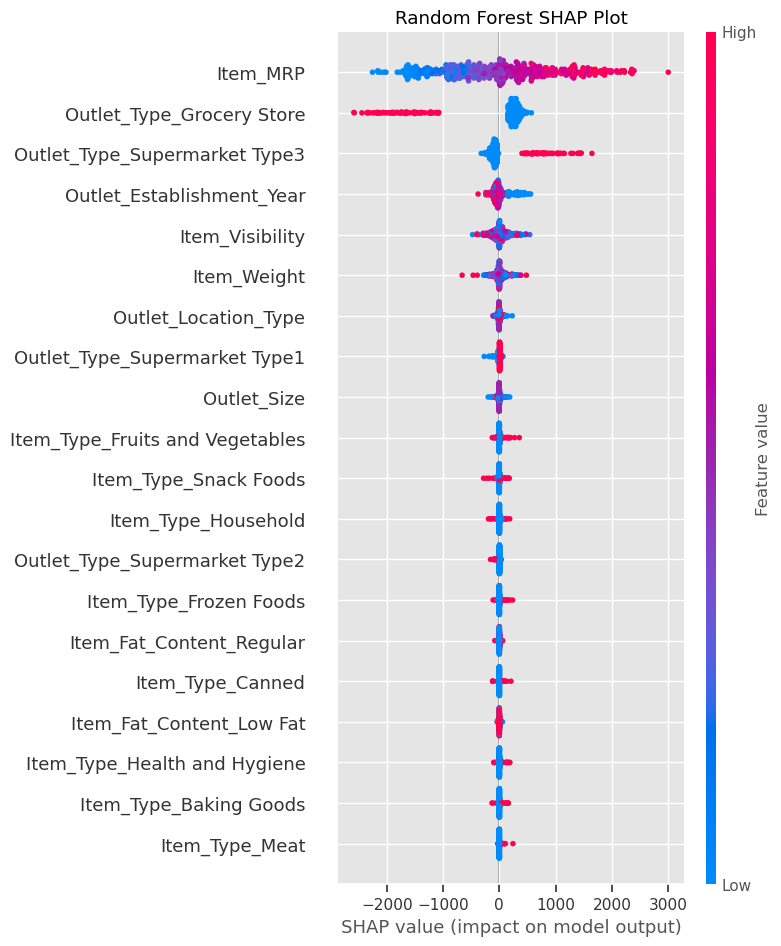

In [82]:
## create a summary plot for Random Forest (dot/default version)
fig2 = shap.summary_plot(rf_shap_values, features=X_shap, show=False)

plt.title('Random Forest SHAP Plot')
plt.show();

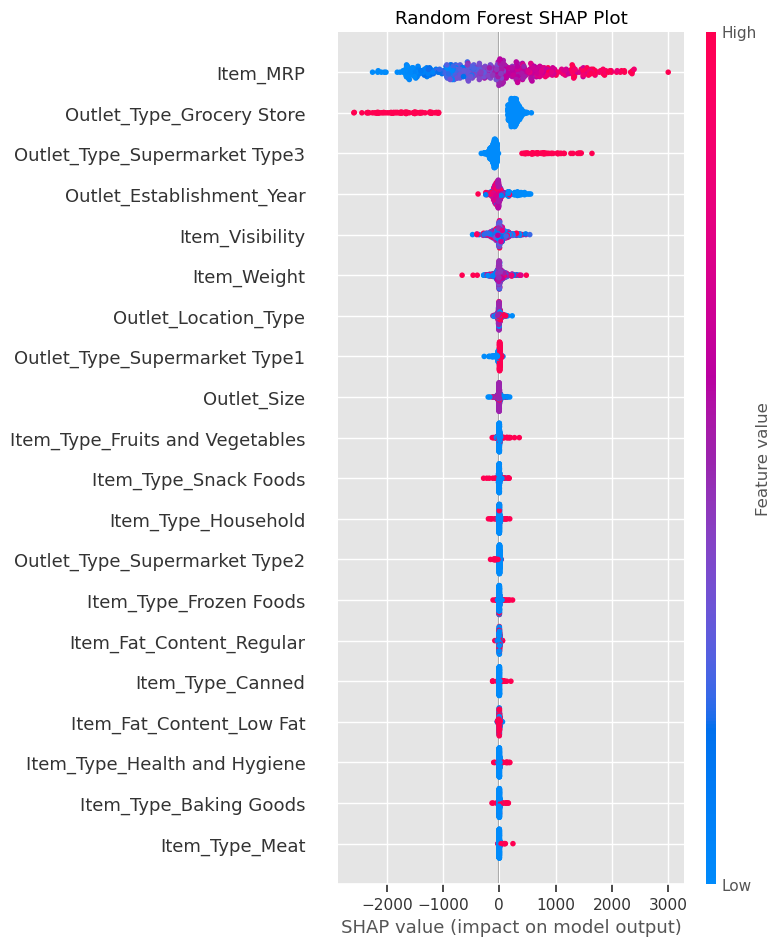

In [83]:
# save visualization
fig, ax = plt.subplots()

shap.summary_plot(rf_shap_values, features=X_shap, show=False)
ax.set_title('Random Forest SHAP Plot')

fig.savefig('images/RFShapDotplot.png')

According to the SHAP Dot Plot the top 3 most important features are:
* Item_MRP - Item_MRP had the largest effect on the model's predictions (since it was the first bar at the top of the graph).
    - Because red values are on the right (positive), we can see the greater the number of sales, the more likely the model would predict the drive up sales.


* Outlet_Type_Grocery_Store - Because the red dots are on the left (negative) we can see that the grocery store has a decline in sales, this model will predict this outlet type yo have lower sales.


* Outlet_Type_Supermarket Type3 - Notice that the blue dots (fewer failures) are only slightly to the left of the 0-line, indicating that the model is only slightly less likely to predict lower sales, compared to the big impact of having a large number of sales.

These are the same top 3 features as the RF Shap bar plot.